Demo notebook for ptycho

Arthur McCray  
November 7, 2025

In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
from pathlib import Path

import numpy as np
import torch

import quantem as em
from quantem.core import config
from quantem.core.datastructures import Dataset4dstem
from quantem.core.ml import CNN2d
from quantem.core.visualization import show_2d


from quantem.diffractive_imaging import (
    PtychographyDatasetRaster,
    DetectorPixelated,
    ObjectDIP,
    ObjectPixelated,
    ProbeDIP,
    ProbePixelated,
    Ptychography,
)

GPU_ID = 1
config.set_device(GPU_ID)
print(f"Using GPU {config.get('device')}")

Using GPU cuda:1


# Ducky

In [3]:
_f = Path("/data/shared/resources/example_data/ducky_251105_20mrad_500A-df_4A-step_5e+04-dose_clean.zip")
dset: Dataset4dstem = em.io.load(_f)
print(dset)

quantem Dataset named '4D-STEM dataset'
  shape: (37, 37, 200, 200)
  dtype: float32
  device: cpu
  origin: [0. 0. 0. 0.]
  sampling: [4.    4.    0.025 0.025]
  units: ['A', 'A', 'A^-1', 'A^-1']
  signal units: 'arb. units'


In [4]:
PROBE_ENERGY = 80e3 # eV
PROBE_SEMIANGLE = 20 # mrad
PROBE_DEFOCUS = 500 # A 

(<Figure size 400x400 with 1 Axes>,
 <Axes: title={'center': '4D-STEM dataset_dp_mean'}>)

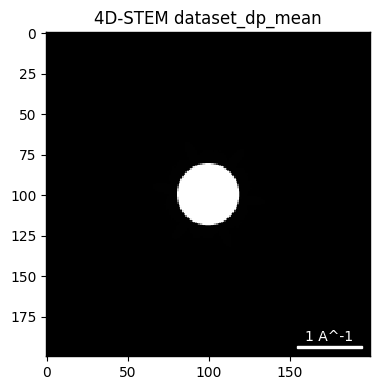

In [5]:
dset.dp_mean.show(show_ticks=True)

quantem Dataset named '4D-STEM dataset(slice(None, None, None), slice(None, None, None), slice(16, -16, None), slice(16, -16, None))'
  shape: (37, 37, 168, 168)
  dtype: float32
  device: cpu
  origin: [0. 0. 0. 0.]
  sampling: [4.    4.    0.025 0.025]
  units: ['A', 'A', 'A^-1', 'A^-1']
  signal units: 'arb. units'


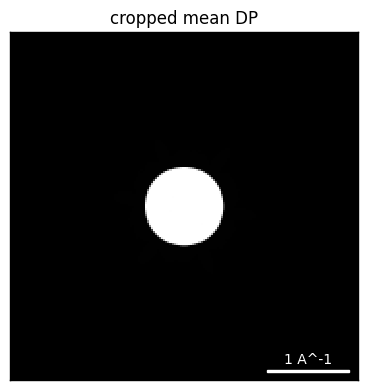

In [93]:
# we cant really bin this down in reciprocal space cuz the probe won't fit, but we can crop a 
# little without losing too much resolution
dset_small: Dataset4dstem = dset[:,:,16:-16,16:-16] # type:ignore # TODO figure out how to static type this properly
# don't bin
# dset_small = dset.bin((1,1,2,2), modify_in_place=False) # type: ignore # TODO fix typing here too 
dset_small.dp_mean.show(title='cropped mean DP')
print(dset_small)

## pixelated

quantEM (in general) is meant to be modular to handle a wide range of situations and experiment types. quantEM ptychography is based on 4 sub-modules: 
- Object model 
    - the sample object
    - Currently have pixelated and DIP, future will include INR, splatting, etc. 
- Probe model
    - the electron probe
    - Currently support pixelated, DIP, and (sort of, largely untested) parametric. Future will include INR
- Detector model
    - to support funky detectors. 
    - Currently support pixelated and (sort of, largely untested) segmented. 
- Dataset model
    - to support arbitrarily collected datasets
    - Currently support just normal raster scans, but future want to support sparse, spiral, arbitrary scans
    
    
Idea for all of these is that if one of the current models doesn't fit your usecase, you can make a new one that does. 

We start by initializing each sub-module. 

A general pattern in quantEM is that everything is constructed from classmethods rather and we protect/restrict `__init__` so that it cannot be called directly. This is to reduce confusion and allow for more explicit, cleaner initializing. 

Calculated best fit rotation = 0 degrees.


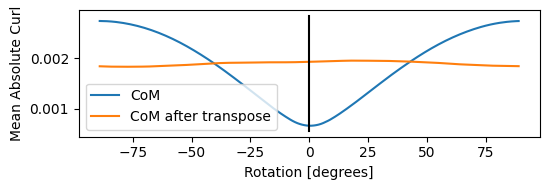

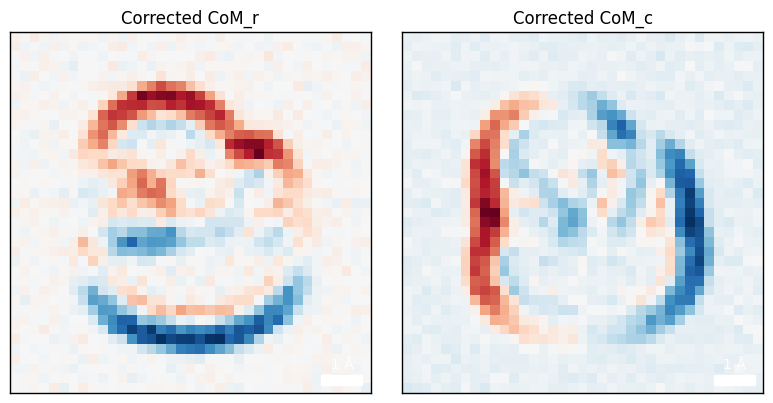

Normalizing intensities:   0%|          | 0/1369 [00:00<?, ?probe position/s]

In [117]:
pdset = PtychographyDatasetRaster.from_dataset4dstem(dset_small)
pdset.preprocess(
    com_fit_function="constant",
    plot_rotation=True,
    plot_com=True,
)

obj_model_pix = ObjectPixelated.from_uniform( # also from_array and from_random 
    obj_type="pure_phase",
)

probe_params = {
    "energy": PROBE_ENERGY,
    "defocus": PROBE_DEFOCUS,
    "semiangle_cutoff": PROBE_SEMIANGLE,
}

probe_model_pix = ProbePixelated.from_params(
    probe_params=probe_params,
)

detector_model = DetectorPixelated()

In [118]:
# tensorboard logging is optional 
from quantem.diffractive_imaging.logger_ptychography import LoggerPtychography

logger = None
# logger = LoggerPtychography(
#     # log_dir = "../logs/",
#     log_dir = data_dir / "logs",
#     run_prefix=dset.name,
#     run_suffix="",
#     log_images_every=10,
#     log_probe_images=False,
# )

Once the sub-models are initialized, we can create our `Ptychography` using the `from_models` classmethod. 

In [119]:
ptycho_pix = Ptychography.from_models( 
    dset=pdset,
    obj_model=obj_model_pix,
    probe_model=probe_model_pix,
    detector_model=detector_model,
    logger=logger,
    rng=42, 
)

In an ideal world we wouldn't have a `Ptychography.preprocess` function, but it seems to be necessary. Also if you haven't preprocessed your dataset it will do so here, but I generally recommend preprocessing the dset first.

In [120]:
ptycho_pix.preprocess(
    obj_padding_px=(32, 32),
    val_ratio=0.0,
)

We can now do the actual reconstruction. There are three sets of options/parameters that we can/must specify. Currently this is done with dictionaries, but we might update this to use dataclasses or higher level configs so that there are tab autocomplete options. 

The only required items to set are the optimizer (not sure if it fails if you don't set one, but it should). You set the optimizer for the object, probe, and dataset seperately (within the same `opt_params`), so you can use different lrs or optimizer types. Additional kwaargs can be specified and they'll be passed to the optimizer as well. 

  0%|          | 0/50 [00:00<?, ?it/s]

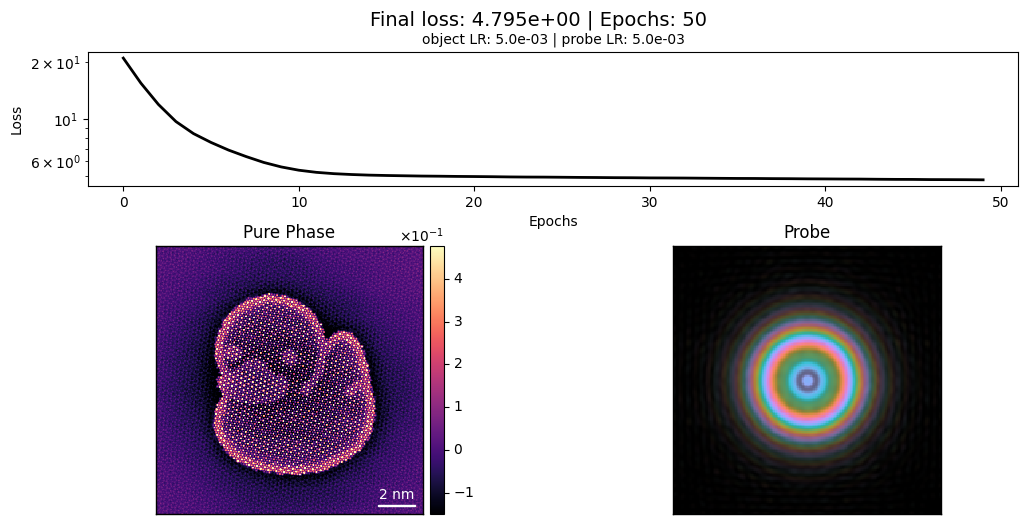

In [121]:
opt_params = {
    "object": {
        "type": "adamw", # support adam, adamw, sgd as strings
        "lr": 5e-3,
    },
    "probe": {
        "type": torch.optim.AdamW, # this also works
        "lr": 5e-3,
    },
}


ptycho_pix.reconstruct(
    num_iter=50,
    reset=True,
    optimizer_params=opt_params,
    batch_size=125,
    device="gpu",
).visualize()

(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: title={'center': 'pixelated pure_phase | 50 epochs'}>,
        <Axes: title={'center': 'zoom r1'}>,
        <Axes: title={'center': 'zoom r2'}>], dtype=object))

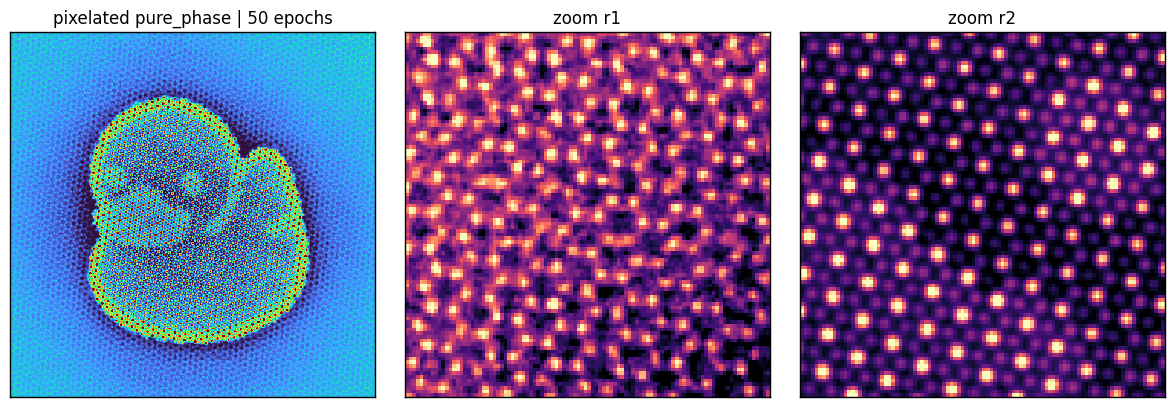

In [ ]:
r1 = slice(10, 110), slice(10, 110)
r2 = slice(220, 320), slice(220, 320)
ph = ptycho_pix.obj_cropped.sum(0)
if ptycho_pix.obj_model.obj_type != "potential":
    ph = np.angle(ph)
show_2d(
    [
        ph,
        ph[r1],
        ph[r2],
    ],
    cmap=("turbo", "magma", "magma"),
    title=[
        f"pixelated {ptycho_pix.obj_model.obj_type} | {ptycho_pix.num_epochs} epochs",
        "zoom r1",
        "zoom r2",
    ],
)

you can continue the reconstruction as is, or pass in new optimizer parameters. This passing in a optimizer type of "none" allows you to not learn (i.e. fix) that model.

  0%|          | 0/150 [00:00<?, ?it/s]

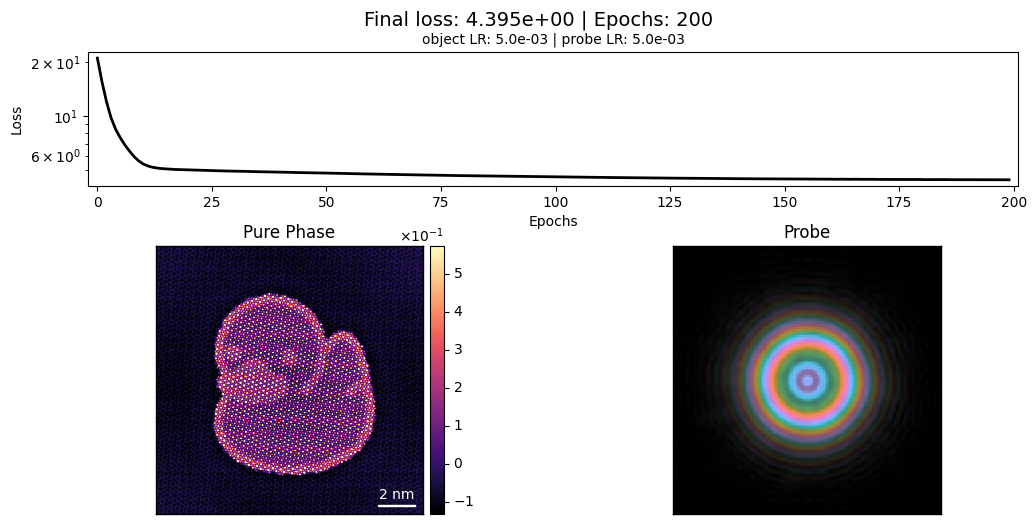

In [124]:
ptycho_pix.reconstruct(
    num_iter=150,
).visualize()


(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: title={'center': 'pixelated pure_phase | 200 epochs'}>,
        <Axes: title={'center': 'zoom r1'}>,
        <Axes: title={'center': 'zoom r2'}>], dtype=object))

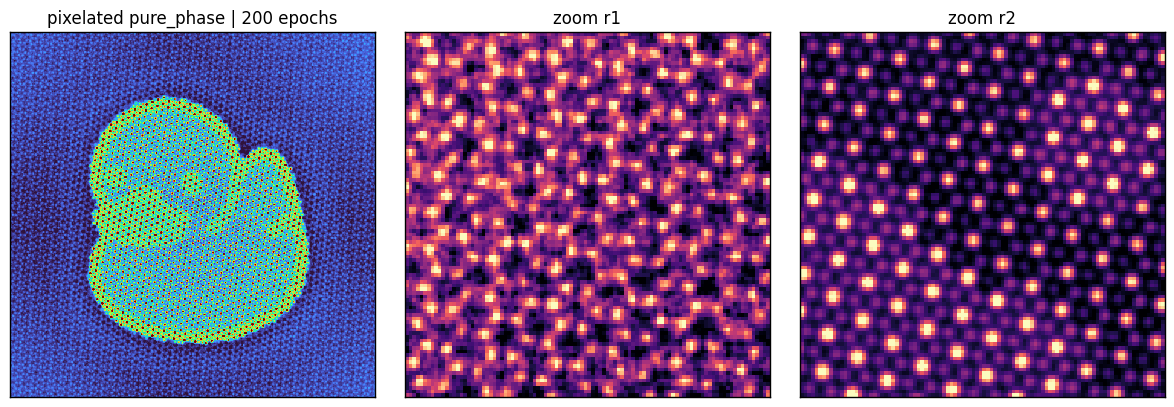

In [ ]:
ph = ptycho_pix.obj_cropped.sum(0)
if ptycho_pix.obj_model.obj_type != "potential":
    ph = np.angle(ph)
show_2d(
    [
        ph,
        ph[r1],
        ph[r2],
    ],
    cmap=("turbo", "magma", "magma"),
    title=[
        f"pixelated {ptycho_pix.obj_model.obj_type} | {ptycho_pix.num_epochs} epochs",
        "zoom r1",
        "zoom r2",
    ],
)

## DIP

  0%|          | 0/5 [00:00<?, ?it/s]

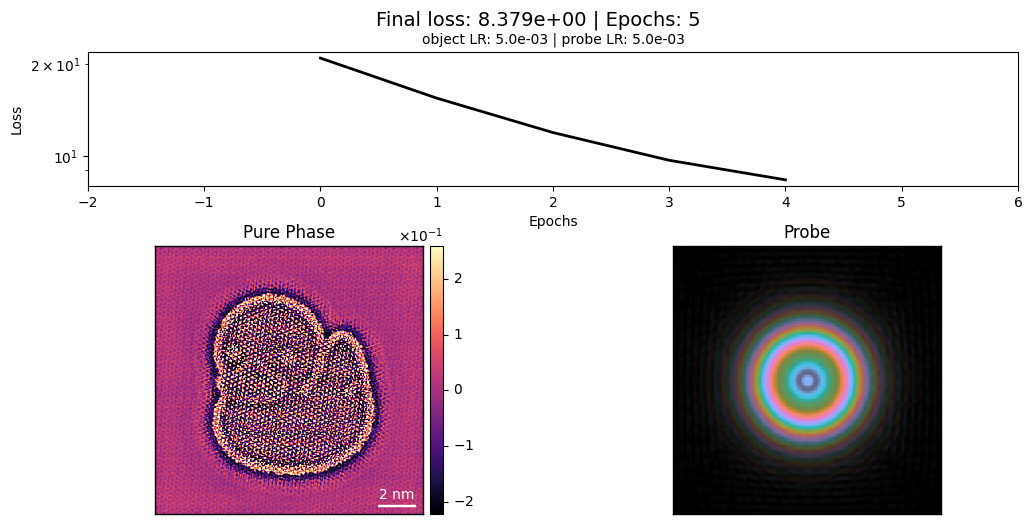

In [147]:
ptycho_pix2 = Ptychography.from_ptychography(
    ptycho=ptycho_pix,
)
ptycho_pix2.reconstruct(
    num_iter=5,
    reset=True,
).visualize()

  0%|          | 0/150 [00:00<?, ?it/s]

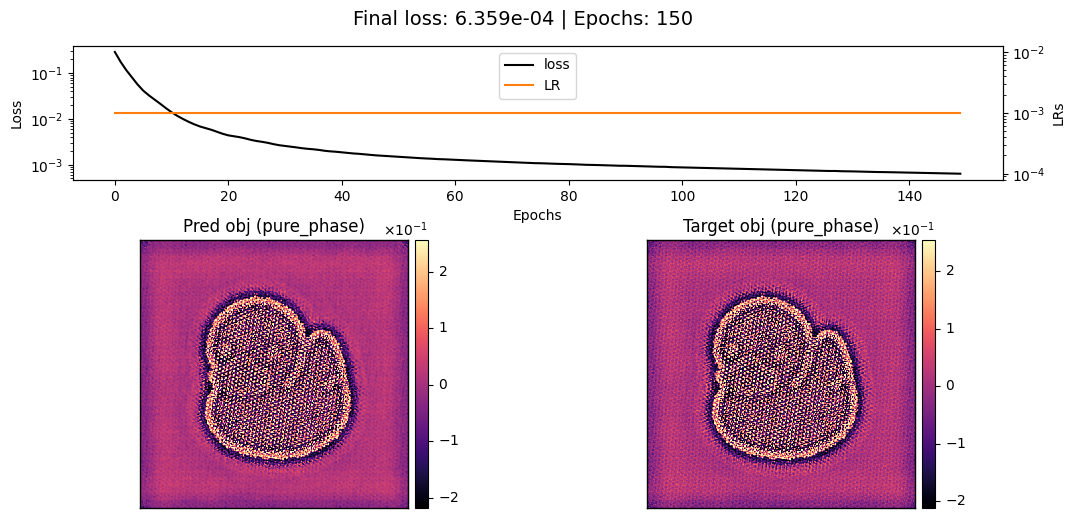

  0%|          | 0/50 [00:00<?, ?it/s]

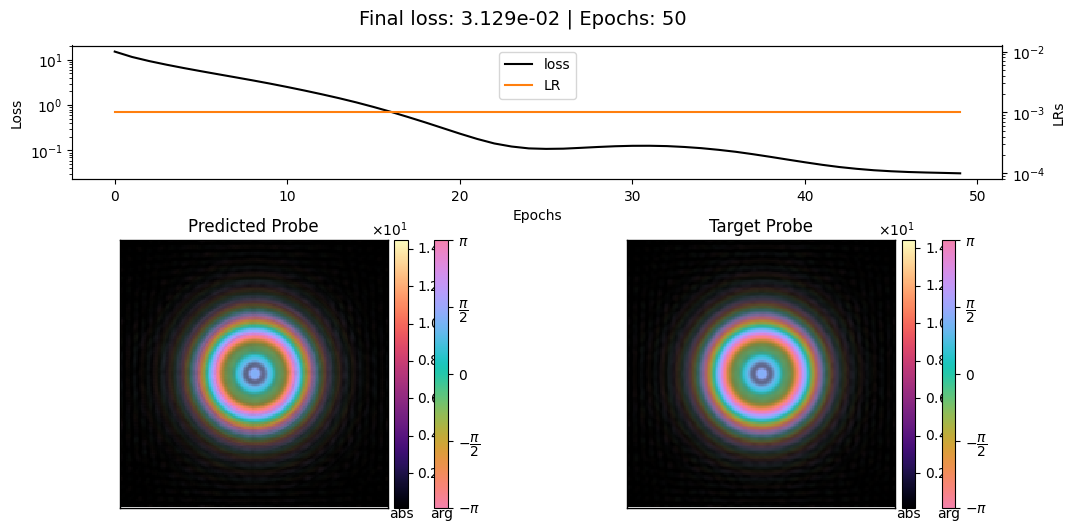

In [148]:
model_dip = CNN2d(
    in_channels=1,
    use_skip_connections=True,
    dtype=torch.complex64 if ptycho_pix.obj_model.obj_type == "complex" else torch.float32,
    final_activation="softplus" if ptycho_pix.obj_model.obj_type == "potential" else "identity",
)
obj_model_dip = ObjectDIP.from_pixelated(
    model=model_dip,
    pixelated=ptycho_pix2.obj_model,
)

probe_dip = CNN2d(
    in_channels=1,
    use_skip_connections=True,
    dtype = torch.complex64,
)
probe_model_dip = ProbeDIP.from_pixelated(
    model=probe_dip,
    pixelated=ptycho_pix2.probe_model,
)

obj_model_dip.pretrain(
    num_epochs=150, # 150 for complex 
    optimizer_params={
        "type": torch.optim.Adam,
        "lr": 1e-3,
    },
    scheduler_params={
        "type": "plateau",
        "factor": 0.5,
    },
    device=config.get("device"),
)

probe_model_dip.pretrain(
    num_epochs=50,
    optimizer_params={
        "type": torch.optim.Adam,
        "lr": 1e-3,
    },
    scheduler_params={
        "type": "plateau",
        "factor": 0.5,
    },
    device=config.get("device"),
)

ptycho_dip = Ptychography.from_models(
    dset=pdset,
    obj_model=obj_model_dip,
    probe_model=probe_model_dip,
    detector_model=detector_model,
    device=config.get("device"),
    logger=logger,
)

ptycho_dip.preprocess(
    obj_padding_px=(32, 32),
)

  0%|          | 0/25 [00:00<?, ?it/s]

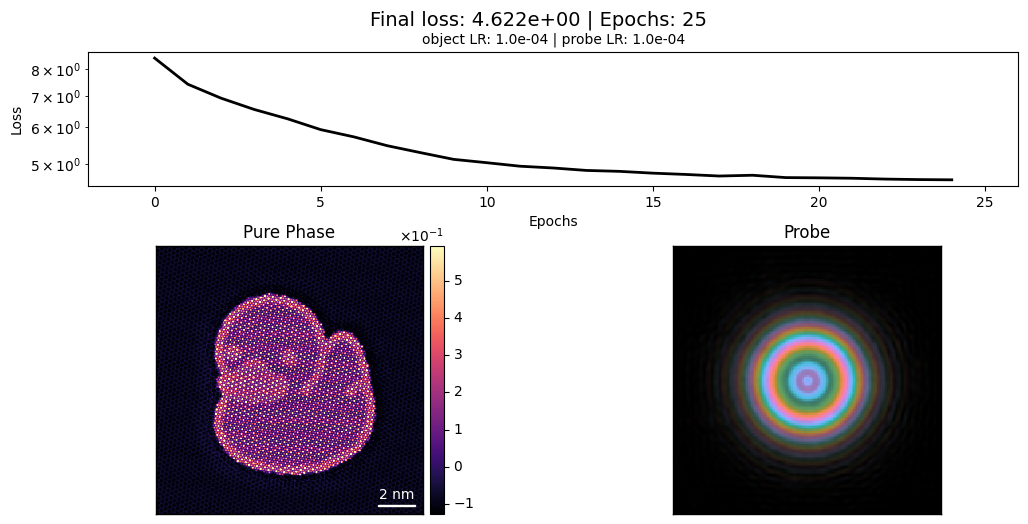

In [149]:
opt_params = {  
    "object": {
        "type": "adam",  
        "lr": 1e-4,
    },
    "probe": {
        "type": "adam",
        "lr": 1e-4,
    },
}

scheduler_params = {
    "object": {
        "type": "plateau",
    },
    "probe": {
        "type": "plateau",
    },
}
constraints = {
}

ptycho_dip.reconstruct(
    num_iter=25,
    reset=True,
    optimizer_params=opt_params,
    scheduler_params=scheduler_params,
    constraints=constraints,
    batch_size=128,
    device='gpu',
    store_iterations_every=1, 
).visualize()

(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: title={'center': 'DGP pure_phase | 25 epochs'}>,
        <Axes: title={'center': 'zoom r1'}>,
        <Axes: title={'center': 'zoom r2'}>], dtype=object))

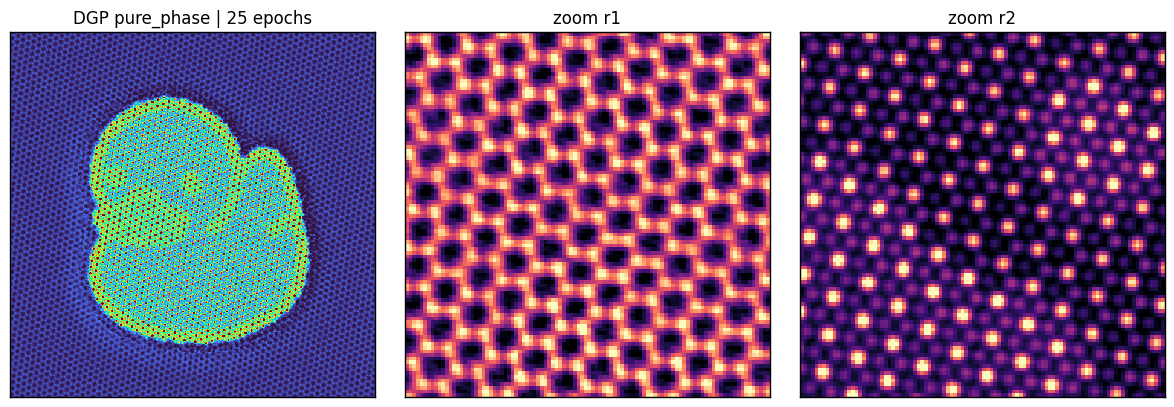

In [155]:
ph = ptycho_dip.obj_cropped.sum(0)
if ptycho_dip.obj_model.obj_type != "potential":
    ph = np.angle(ph)
show_2d(
    [
        ph,
        ph[r1],
        ph[r2],
    ],
    cmap=("turbo", "magma", "magma"),
    title=[
        f"DGP {ptycho_dip.obj_model.obj_type} | {ptycho_dip.num_epochs} epochs",
        "zoom r1",
        "zoom r2",
    ],
)

  0%|          | 0/50 [00:00<?, ?it/s]

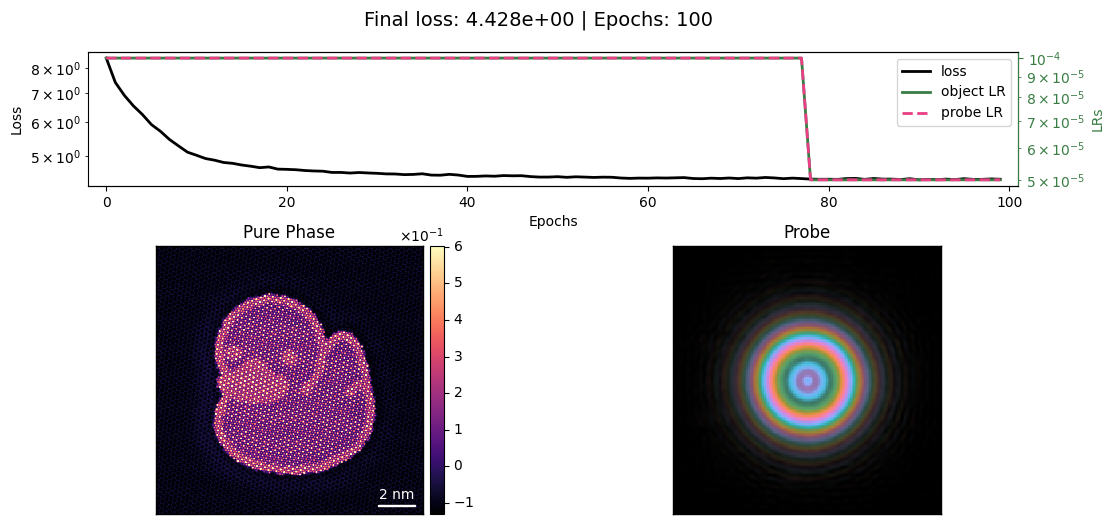

In [160]:
ptycho_dip.reconstruct(50).visualize()

(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: title={'center': 'DGP pure_phase | 100 epochs'}>,
        <Axes: title={'center': 'zoom r1'}>,
        <Axes: title={'center': 'zoom r2'}>], dtype=object))

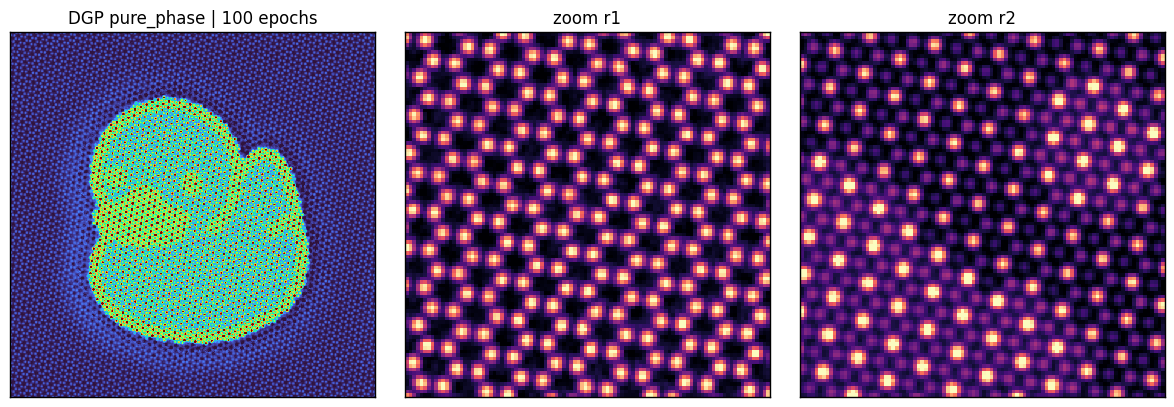

In [161]:
ph = ptycho_dip.obj_cropped.sum(0)
if ptycho_dip.obj_model.obj_type != "potential":
    ph = np.angle(ph)
show_2d(
    [
        ph,
        ph[r1],
        ph[r2],
    ],
    cmap=("turbo", "magma", "magma"),
    title=[
        f"DGP {ptycho_dip.obj_model.obj_type} | {ptycho_dip.num_epochs} epochs",
        "zoom r1",
        "zoom r2",
    ],
)

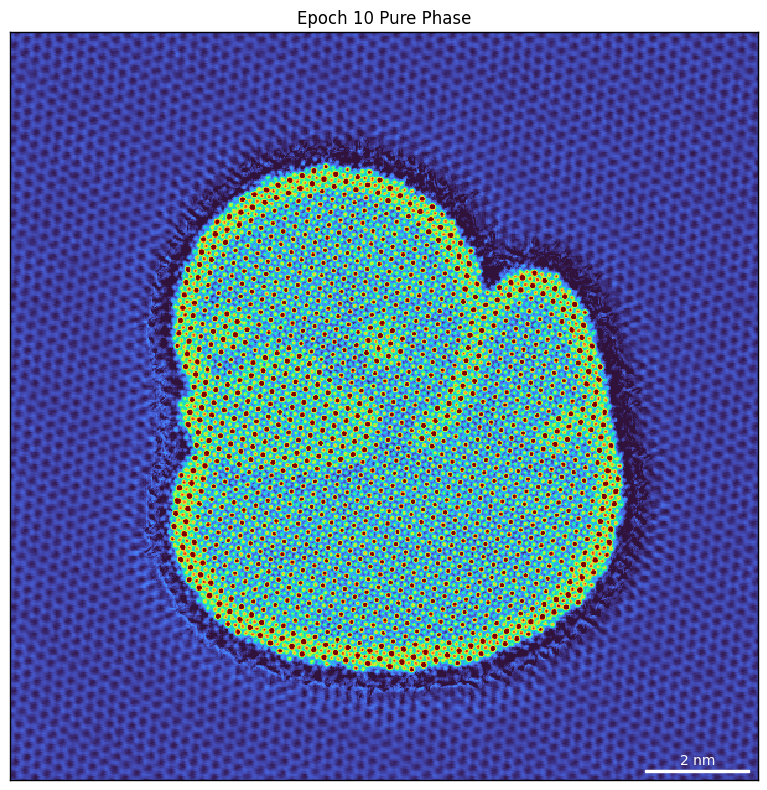

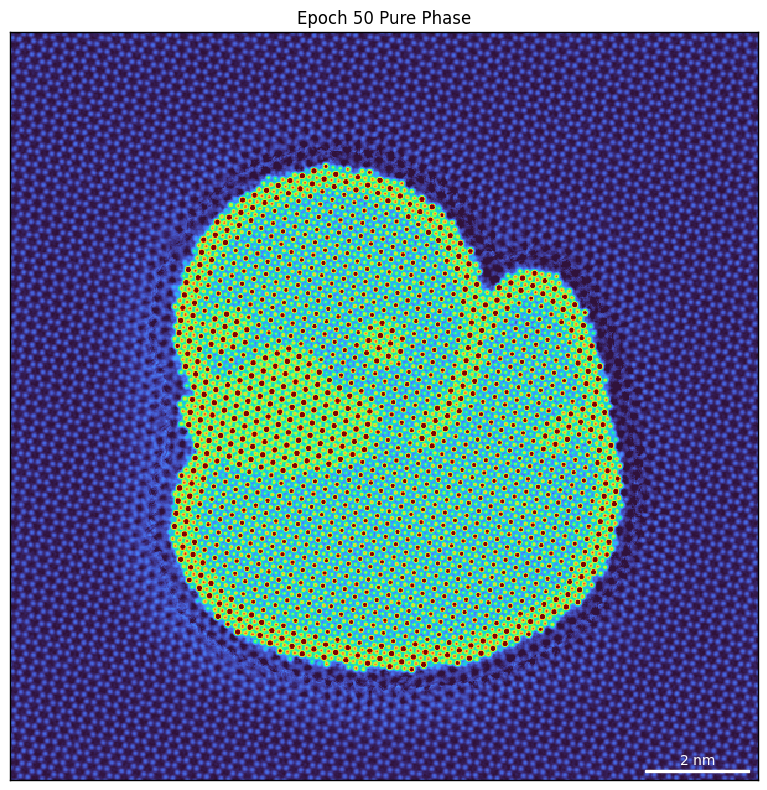

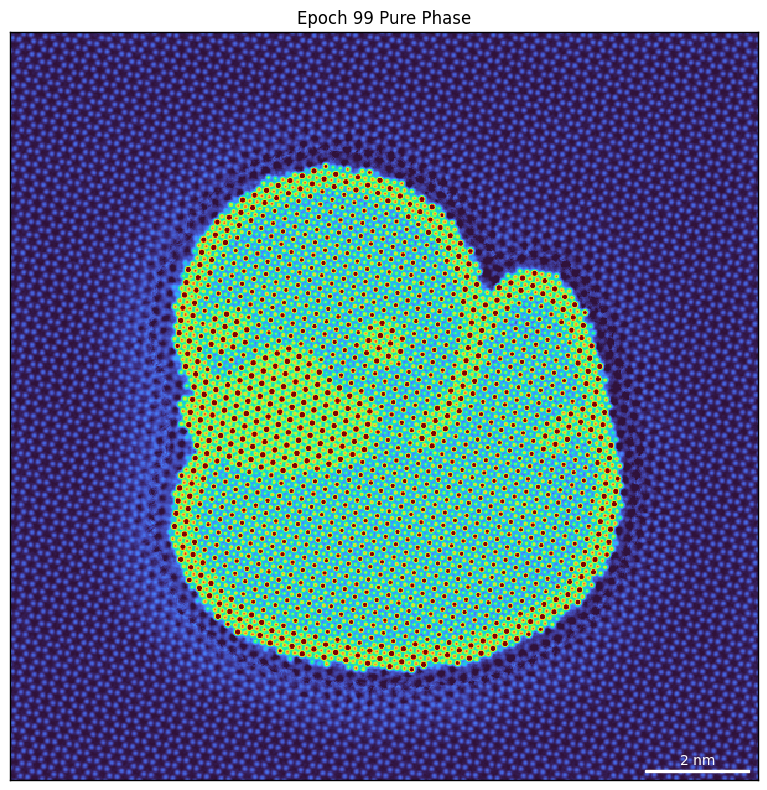

In [ ]:
ptycho_dip.show_obj(snapshot_iter=10, axsize=(8,8), cmap="turbo")
ptycho_dip.show_obj(snapshot_iter=50, axsize=(8,8), cmap="turbo")

## save/load

In [133]:
ptycho_dip.save("../data/ptycho_dip.zip", mode='o')

Saving ptychography object to ../data/ptycho_dip.zip


In [134]:
ptycho_dip2 = Ptychography.from_file("../data/ptycho_dip.zip",dset=pdset)

  0%|          | 0/5 [00:00<?, ?it/s]

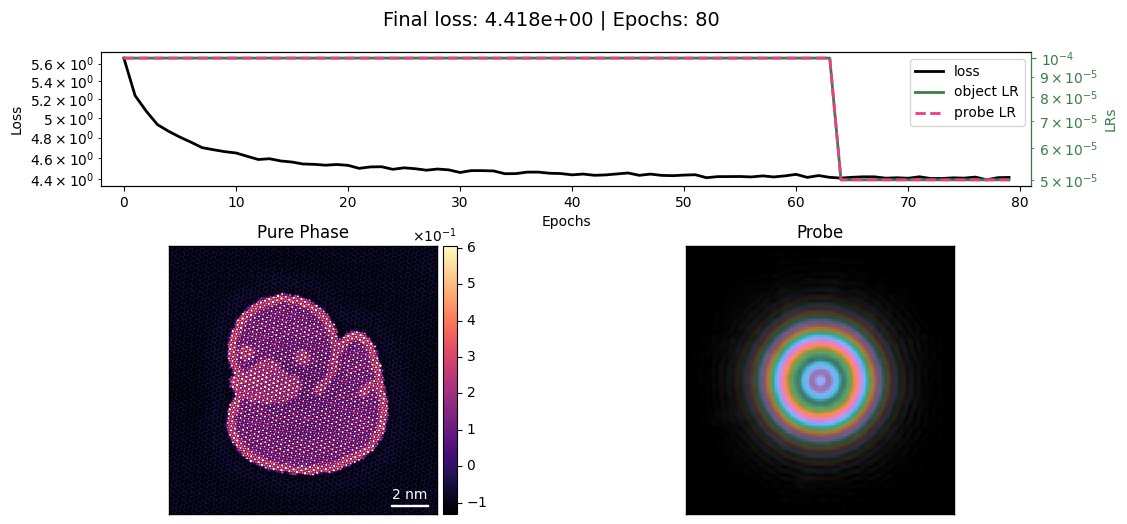

In [135]:
ptycho_dip2.reconstruct(
    num_iter=5,
    device='gpu',
).visualize()

(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: title={'center': 'DGP pure_phase | 80 epochs'}>,
        <Axes: title={'center': 'zoom r1'}>,
        <Axes: title={'center': 'zoom r2'}>], dtype=object))

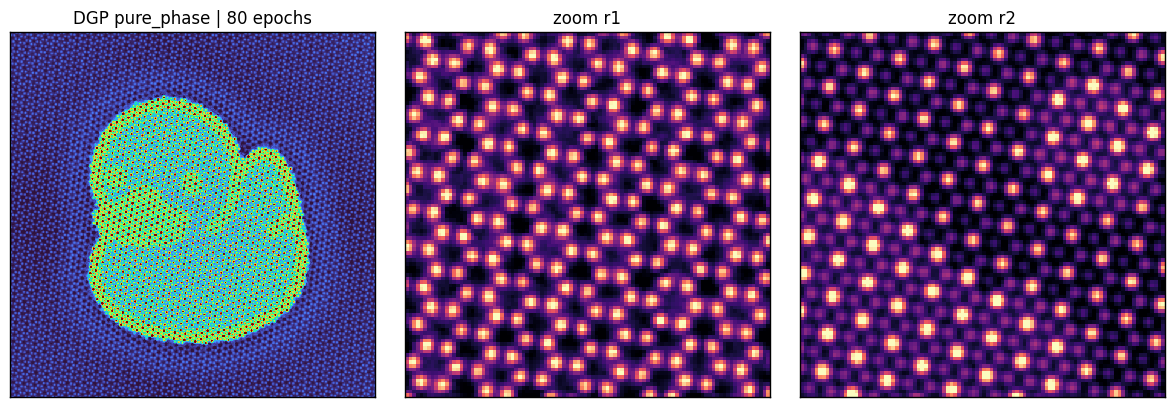

In [137]:
ph = ptycho_dip2.obj_cropped.sum(0)
if ptycho_dip2.obj_model.obj_type != "potential":
    ph = np.angle(ph)
show_2d(
    [
        ph,
        ph[r1],
        ph[r2],
    ],
    cmap=("turbo", "magma", "magma"),
    title=[
        f"DGP {ptycho_dip2.obj_model.obj_type} | {ptycho_dip2.num_epochs} epochs",
        "zoom r1",
        "zoom r2",
    ],
)